# Non-Linear Dimensionality Reduction
The objective of this assignment is to get familiarize with `AutoEncoders` which can be used for non-linear dimensionality reduction.

## Datasets 
- CIFAR10

## Packages Used
- Pytorch 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

### Load CIFAR 10 Dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Train Data shape:", trainset.data.shape)
print("Test Data shape:", testset.data.shape)

Files already downloaded and verified
Files already downloaded and verified
Train Data shape: (50000, 32, 32, 3)
Test Data shape: (10000, 32, 32, 3)


### Visualize the Data

torch.Size([16, 3, 32, 32])
torch.Size([16])


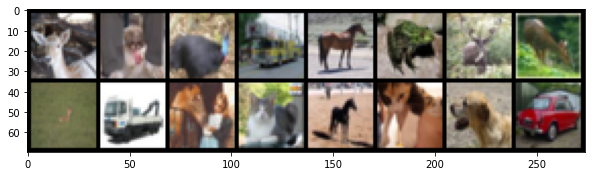

In [3]:
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))

### Define Model
Refer ``` torch.nn ``` [link](https://pytorch.org/docs/stable/nn.html) 

Experiment with different architectures of encoder and decoder i.e
- encoder and decoder is fully connected layers
- encoder and decoder is combination of convolution layers + fully connected layers
- encoder and decoder is fully convolutional layers.

#### There are 3 models created

- encoder and decoder is fully connected layers - Autoencoder1
- encoder and decoder is combination of convolution layers + fully connected layers - Autoencoder2
- encoder and decoder is fully convolutional layers - Autoencoder3

In [4]:
class Autoencoder1(nn.Module):
    def __init__(self):
        super(Autoencoder1, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            # Write your code here
#             Fully Connected Layers only
            nn.Flatten(),
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            
        )
        self.decoder = nn.Sequential(
            # Write your code here
#             Fully Connected Layers only
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 32*32*3),
            nn.ReLU(),
            nn.Unflatten(1,(3,32,32)),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

class Autoencoder2(nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            # Write your code here
#             Combination of Convolution and Fully Connected Layers
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 15, 6, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(15*6*6, 128),
            nn.ReLU(),
            
        )
        self.decoder = nn.Sequential(
            # Write your code here
#            Combination of Convolution and Fully Connected Layers
            nn.Linear(128,15*6*6),
            nn.ReLU(),
            nn.Unflatten(1,(15,6,6)),
            nn.ConvTranspose2d(15, 12, 6, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

class Autoencoder3(nn.Module):
    def __init__(self):
        super(Autoencoder3, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            # Write your code here
#             Fully Convolutional Layers only
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 15, 6, stride=2, padding=0),
            nn.ReLU(),
            
        )
        self.decoder = nn.Sequential(
            # Write your code here        
#             Fully Convolution Layer
            nn.ConvTranspose2d(15, 12, 6, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [5]:
def print_model(encoder, decoder):
    print("############## Encoder ##############")
    print(encoder)
    print("############## Decoder ##############")
    print(decoder)
    print("")

def create_model(m_type):
    if m_type == 1:
        autoencoder = Autoencoder1().cuda()
    elif m_type == 2:
        autoencoder = Autoencoder2().cuda()
    else:
        autoencoder = Autoencoder3().cuda()
    print_model(autoencoder.encoder, autoencoder.decoder)
    return autoencoder

### Loss and Optimizer

In [6]:
def model_creation(m_type):
    autoencoder = create_model(m_type)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())
    return autoencoder, criterion, optimizer

### Training

In [7]:
def train_model(m_type,autoencoder, criterion, optimizer):
    for epoch in range(10):
        running_loss = 0.0
        for i, (inputs, _) in enumerate(trainloader, 0):
                inputs = Variable(inputs).cuda()

                # ============ Forward ============
                encoded, outputs = autoencoder(inputs)
                loss = criterion(outputs, inputs)
                # ============ Backward ============
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # ============ Logging ============
                running_loss += loss.data
                if i % 2000 == 1999:
                    print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0

    print('Finished Training')
    print('Saving Model...')
    torch.save(autoencoder.state_dict(), "autoencoder" + str(m_type) + ".pt")

#### Encoder and Decoder is fully connected layers - Autoencoder1 -- Training
Model saved as autoencoder1.pt

In [8]:
autoencoder1, criterion1, optimizer1 = model_creation(1)
train_model(1,autoencoder1, criterion1, optimizer1)

############## Encoder ##############
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=128, bias=True)
  (6): ReLU()
)
############## Decoder ##############
Sequential(
  (0): Linear(in_features=128, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=3072, bias=True)
  (5): ReLU()
  (6): Unflatten(dim=1, unflattened_size=(3, 32, 32))
  (7): Sigmoid()
)

[1,  2000] loss: 0.057
[2,  2000] loss: 0.052
[3,  2000] loss: 0.050
[4,  2000] loss: 0.049
[5,  2000] loss: 0.049
[6,  2000] loss: 0.048
[7,  2000] loss: 0.048
[8,  2000] loss: 0.048
[9,  2000] loss: 0.047
[10,  2000] loss: 0.047
Finished Training
Saving Model...


#### Encoder and Decoder is combination of convolution layers + fully connected layers - Autoencoder2 -- Training
Model saved as autoencoder2.pt

In [9]:
autoencoder2, criterion2, optimizer2 = model_creation(2)
train_model(2,autoencoder2, criterion2, optimizer2)

############## Encoder ##############
Sequential(
  (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(12, 15, kernel_size=(6, 6), stride=(2, 2))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=540, out_features=128, bias=True)
  (6): ReLU()
)
############## Decoder ##############
Sequential(
  (0): Linear(in_features=128, out_features=540, bias=True)
  (1): ReLU()
  (2): Unflatten(dim=1, unflattened_size=(15, 6, 6))
  (3): ConvTranspose2d(15, 12, kernel_size=(6, 6), stride=(2, 2))
  (4): ReLU()
  (5): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (6): Sigmoid()
)

[1,  2000] loss: 0.021
[2,  2000] loss: 0.011
[3,  2000] loss: 0.010
[4,  2000] loss: 0.009
[5,  2000] loss: 0.008
[6,  2000] loss: 0.008
[7,  2000] loss: 0.008
[8,  2000] loss: 0.008
[9,  2000] loss: 0.008
[10,  2000] loss: 0.008
Finished Training
Saving Model...


#### Encoder and Decoder is fully convolutional layers - Autoencoder3 -- Training
Model saved as autoencoder3.pt

In [10]:
autoencoder3, criterion3, optimizer3 = model_creation(3)
train_model(3,autoencoder3, criterion3, optimizer3)

############## Encoder ##############
Sequential(
  (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(12, 15, kernel_size=(6, 6), stride=(2, 2))
  (3): ReLU()
)
############## Decoder ##############
Sequential(
  (0): ConvTranspose2d(15, 12, kernel_size=(6, 6), stride=(2, 2))
  (1): ReLU()
  (2): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): Sigmoid()
)

[1,  2000] loss: 0.013
[2,  2000] loss: 0.006
[3,  2000] loss: 0.005
[4,  2000] loss: 0.005
[5,  2000] loss: 0.005
[6,  2000] loss: 0.005
[7,  2000] loss: 0.004
[8,  2000] loss: 0.004
[9,  2000] loss: 0.004
[10,  2000] loss: 0.004
Finished Training
Saving Model...


### Load the saved model and Reconstruct the image

In [11]:
def load_model(m_type,autoencoder):
    autoencoder.load_state_dict(torch.load("/content/autoencoder" + str(m_type) + ".pt"))
    # autoencoder.load_state_dict(torch.load("./autoencoder" + str(m_type) + ".pt"))
    return autoencoder

#### Provide Qualitative Results and Aanlysis with different encoder and decoder architectures as mentioned above.

In [12]:
def test_model(autoencoder):
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
    imshow(torchvision.utils.make_grid(images))

    images = Variable(images).cuda()

    print("Reconstructed image")
    decoded_imgs = autoencoder(images)[1]
    imshow(torchvision.utils.make_grid(decoded_imgs.data.cpu()))

#### Reconstruct the image for Autoencoder1

GroundTruth:    cat  ship  ship plane  frog


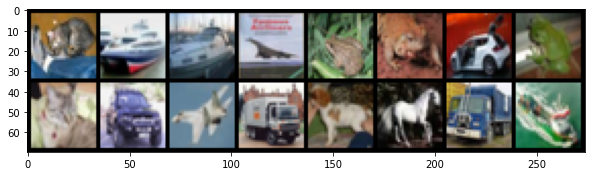

Reconstructed image


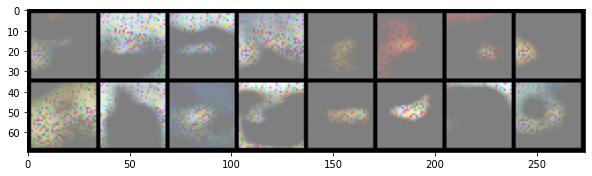

In [13]:
autoencoder1 = load_model(1,autoencoder1)
test_model(autoencoder1)

#### Reconstruct the image for Autoencoder2

GroundTruth:    cat  ship  ship plane  frog


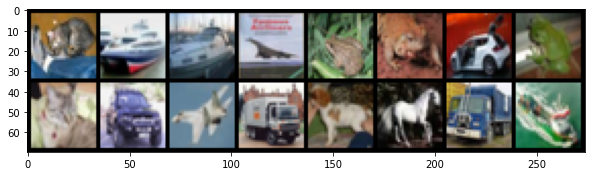

Reconstructed image


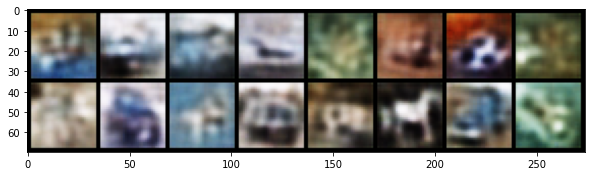

In [14]:
autoencoder2 = load_model(2,autoencoder2)
test_model(autoencoder2)

#### Reconstruct the image for Autoencoder3

GroundTruth:    cat  ship  ship plane  frog


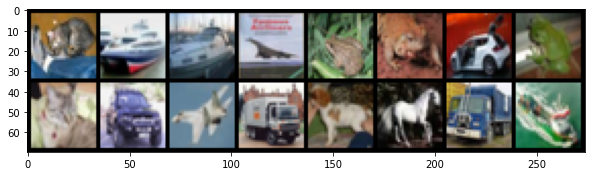

Reconstructed image


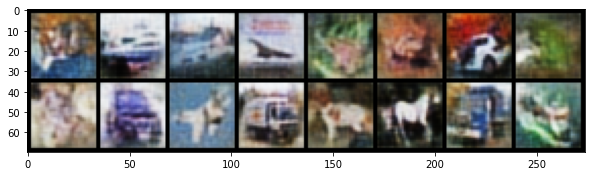

In [15]:
autoencoder3 = load_model(3,autoencoder3)
test_model(autoencoder3)

#### 2.1 What are the Applications of Autoencoders and different types of Autoencoders

**Different Applications of Autoencoders**
- Data Compression
- Image Denoising
- Dimensionality Reduction
- Feature Extraction
- Image Generation
- Image colourisation

**Different Types of Autoencoders**
1. Denoising autoencoder - Denoising autoencoders add some noise to the input image and learn to remove it
2. Sparse Autoencoder - Sparse autoencoders have hidden nodes greater than input nodes.
3. Deep Autoencoder -  A deep autoencoder is composed of two symmetrical deep networks having four to five shallow layers
4. Convolutional Autoencoder - Convolutional Autoencoders learn to encode the input in a set of simple signals and then reconstruct the input from them
5. Variational Autoencoder - This type of autoencoder can generate new images just like GANs.

#### 2.2 PCA versus Autoencoders. Give detailed differences between them. (can use equations in latex and figures for the justification).

**PCA**
PCA essentially learns a linear transformation that projects the data into another space, where vectors of projections are defined by variance of the data.

**Autoencoders**
Autoencoder is dimensionality reduction technique. Autoencoder is fully capable of not only handling the linear transformation but also the non-linear transformation. 

**Differences between PCA and Autoencoders**
- PCA is essentially a linear transformation but Auto-encoders are capable of modelling complex non linear functions. Since Autoencoders use non linera activation functions, they can learn non-linear transformations. If the linear activation with a single deep layer is used in Autoencoder then it acts similar to PCA
- Autoencoders are more prone to overfitting due to large number of parameters which may be avoided using regularization and proper design. On other hand PCA is faster and computationally cheaper than autoencoders due to the fact that it finds linear transformations which can be done in linear time.
- While role of PCA is only restricted to dimensionality reduction, Autoencoders have a wide variety of applications like Image reconstruction, Image denoising, compression of data, etc. Autoencoder architecture can be modified to tailor suit according to the specific requirements.

<br>
<br>
The below illustration shows that Autoencoders can identify Non-Linear Transformations while PCA can only identify Linear Transformations
<br><br>

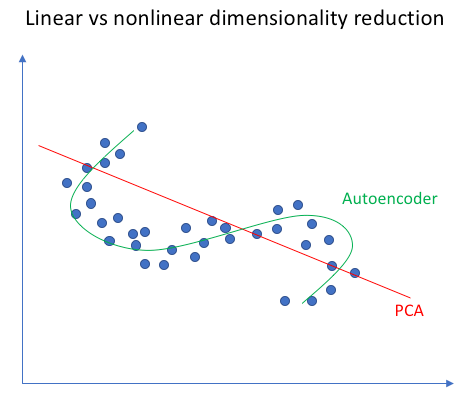

<br>
Here in the below image we can see that both Autoencoders and PCA perform almost same on linear surfaces but while in Non-Linear surfaces, PCA does not perform well due to the fact that it can learn only linear decision boundaries (attributes which are co-linear in nature) while Autoencoders with the help of non-linear activation functions can easily resconstruct non-linear surfaces.
<br><br>

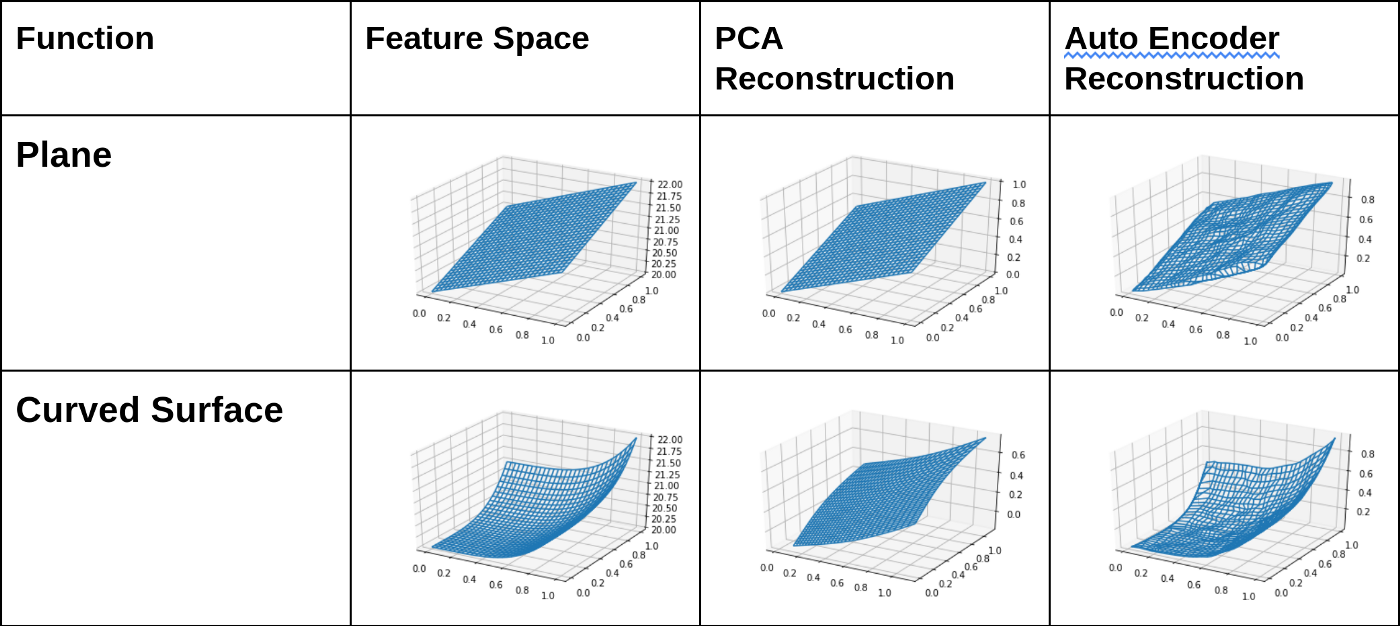